In [607]:
input_linreg =  "../results/zarrs/Hinf_norm_mic_linreg_logscaled_results.zarr/"
input_logreg =  "../results/zarrs/Hinf_norm_bin_logreg_results.zarr/"
linreg_csv = "../results/linreg_logscaled.csv"
logreg_csv = "../results/logreg.csv"

# Plots

In [2]:
import pandas as pd
import numpy as np
import sgkit as sg

import plotly
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt


## Linear regression

In [224]:
ds_linreg_log2 = (sg.load_dataset(input_linreg)
             .assign(MAC= lambda ds: ds.pipe(sg.variant_stats).variant_allele_count[:,:2].min(dim='alleles'))
)


df_linreg_log2 = ds_linreg_log2[['variant_position', 'pvalue', 'p_values.adj', 'effect',
                       'r.squared', 'adj.r.squared', 'mutation', 'gene.name',
                       'gene.product', 'gene.type', 'MAC']].to_pandas()
df_linreg_log2['-log_10(pvalue)'] = - np.log10(df_linreg_log2['pvalue'])

ref = df_linreg_log2['mutation'].str.split().str[0].str[0]
alt = df_linreg_log2['mutation'].str.split().str[0].str[-1]
df_linreg_log2['mutation_type'] = ((df_linreg_log2['mutation'] == '') | (ref == alt)).apply(lambda x: 'synonymous' if x else 'nonsynonymous')

In [759]:
def filter_MAC(dataframe: pd.DataFrame, min_MAC: int) -> pd.DataFrame:
    return dataframe.query("@min_MAC <= MAC")

def filter_pvalue(dataframe: pd.DataFrame, min_pvalue: float) -> pd.DataFrame:
    return dataframe.query('@min_pvalue > pvalue')

def filter_mutation_type(dataframe: pd.DataFrame) -> pd.DataFrame:
    return dataframe.query("mutation_type == 'nonsynonymous'")
    

hover_data = ['pvalue', 'effect', 'r.squared', 'adj.r.squared',
              'mutation', 'gene.name','gene.product', 'gene.type', 'MAC']
              

fig = px.scatter(df_linreg_log2.pipe(filter_MAC, 10), x='variant_position', y='-log_10(pvalue)', color='mutation_type',
                 hover_data=hover_data, labels={'mutation_type': 'Mutation type',
                                                'variant_position': 'Genome coordiante [Mb]',
                                                '-log_10(pvalue)': '-log<sub>10</sub> (p-value)',
                                               'MAC': 'minor allele count',
                                               'gene.name': 'gene name',
                                               'gene.product': 'gene product',
                                               'gene.type': 'gene type'})
fig.update_layout(title='Manhattan plot for linear regression based GWAS')
# plotly.offline.plot(fig, filename='../test/revision-html/Suppl_Material_3_manhattan_linreg_log2.html')

'../test/revision-html/Suppl_Material_3_manhattan_linreg_log2.html'

## Logistic regression

In [292]:
ds_logreg = (sg.load_dataset(input_logreg)
             .assign(MAC= lambda ds: ds.pipe(sg.variant_stats).variant_allele_count[:,:2].min(dim='alleles'))
)

df_logreg = ds_logreg[['variant_position', 'pvalue', 'p_values.adj', 'effect',
                        'mutation', 'gene.name',
                       'gene.product', 'gene.type', 'MAC']].to_pandas()
df_logreg['-log_10(pvalue)'] = - np.log10(ds_logreg['pvalue'])

ref = df_logreg['mutation'].str.split().str[0].str[0]
alt = df_logreg['mutation'].str.split().str[0].str[-1]
df_logreg['mutation_type'] = ((df_logreg['mutation'] == '') | (ref == alt)).apply(lambda x: 'synonymous' if x else 'nonsynonymous')

In [758]:
def filter_MAC(dataframe: pd.DataFrame, max_MAC: int) -> pd.DataFrame:
    return dataframe.query("@max_MAC <= MAC")

hover_data = ['pvalue', 'effect',
              'mutation', 'gene.name','gene.product', 'gene.type', 'MAC']
fig2 = px.scatter(df_logreg.pipe(filter_MAC, 10), x='variant_position', y='-log_10(pvalue)', color='mutation_type',
                 hover_data=hover_data, labels={'mutation_type': 'Mutation type',
                                                'variant_position': 'Genome coordiante [Mb]',
                                                '-log_10(pvalue)': '-log<sub>10</sub> (p-value)',
                                               'MAC': 'minor allele count',
                                               'gene.name': 'gene name',
                                               'gene.product': 'gene product',
                                               'gene.type': 'gene type'})
# plotly.offline.plot(fig2, filename='test2.html')
# fig2.show()
fig2.update_layout(title='Manhattan plot for logistic regression based GWAS')
# plotly.offline.plot(fig2, filename='../test/revision-html/Suppl_Material_4_manhattan_logreg.html')

'../test/revision-html/Suppl_Material_4_manhattan_logreg.html'

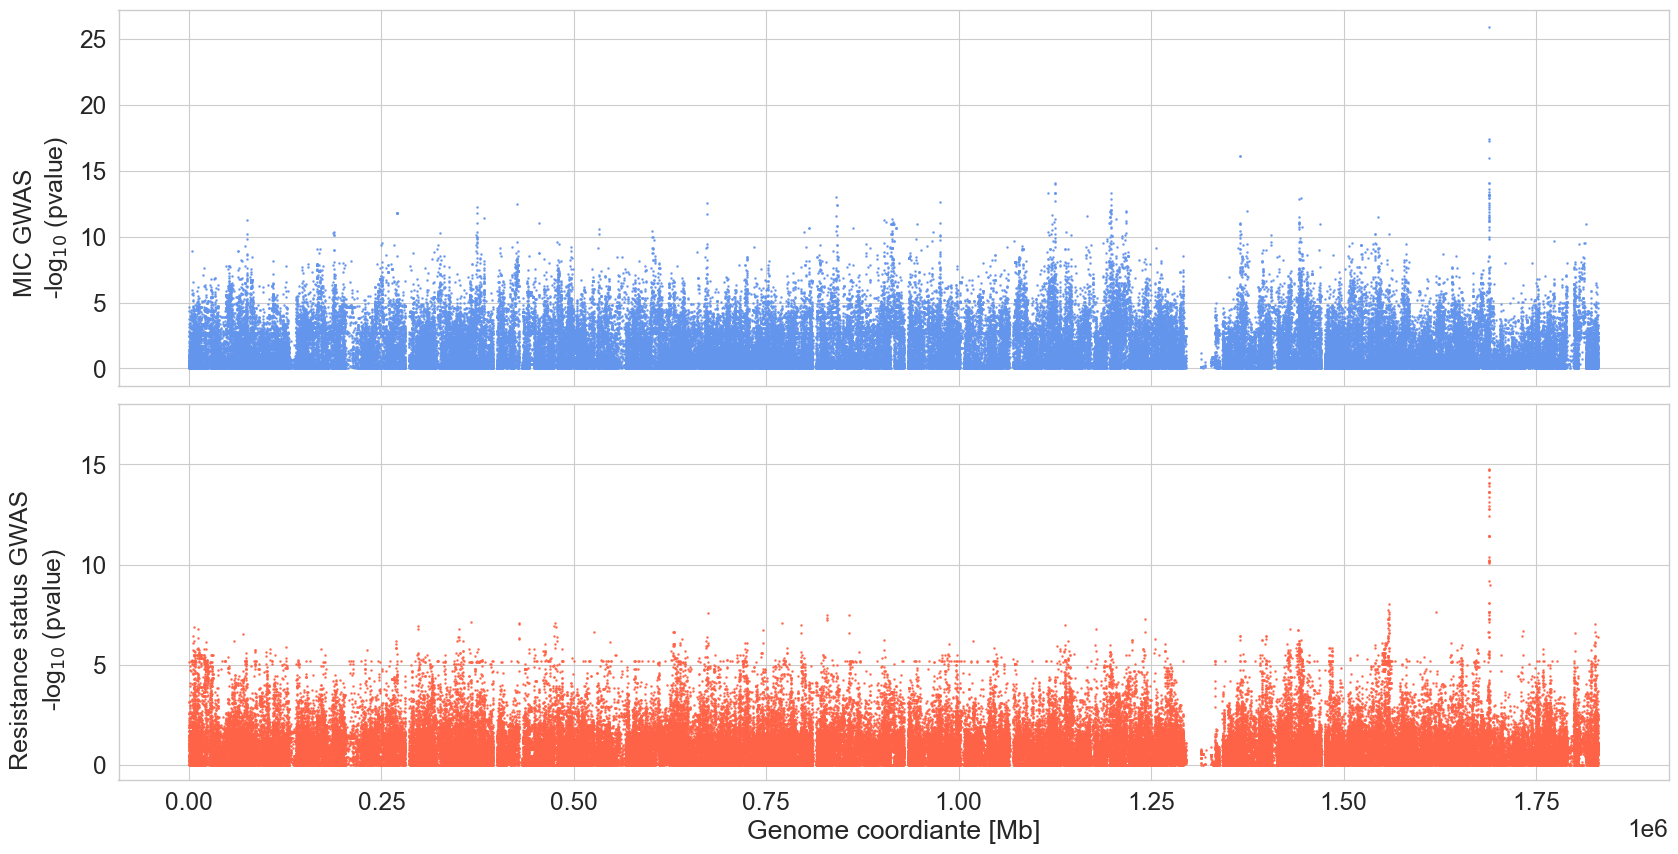

In [427]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=2)
sns.set_style('whitegrid')

a4_dims = ( 8.27, 10 /2)
fig, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(20,10))


marker_size = 2.5
fontsize_label = 'small'

## Linear

sns.scatterplot(data=df_linreg_log2, x='variant_position', y='-log_10(pvalue)',   ax=ax[0], edgecolor=None, s=marker_size,  color='cornflowerblue')
ax[0].set(xlabel='Genome coordiante [Mb]', ylabel='-log$_{10}$ (pvalue)')
# ax[0].set_title('Linear regression')

ax[0].set( ylabel='')
ax[0].text(-0.06, 0.25, "MIC GWAS", fontsize=18, ha='center', rotation='vertical', transform=ax[0].transAxes)
ax[0].text(-0.04, 0.25, "-log$_{10}$ (pvalue)", fontsize=18, ha='center', rotation='vertical', transform=ax[0].transAxes)


## Logistic

sns.scatterplot(data=df_logreg, x='variant_position', y='-log_10(pvalue)', ax=ax[1], edgecolor=None, s=marker_size , color='tomato')
ax[1].set(xlabel='Genome coordiante [Mb]', ylabel='-log$_{10}$ (pvalue)')
# ax[1].set_title('Logistic regression')

ax[1].set(ylabel='')
ax[1].text(-0.07, 0.4, "Resistance status GWAS" , fontsize=18, va='center',  rotation='vertical', transform=ax[1].transAxes)
ax[1].text(-0.05, 0.4, "-log$_{10}$ (pvalue)" , fontsize=18, va='center',  rotation='vertical', transform=ax[1].transAxes)

ax[1].set_yticks([0,5,10,15,18])

ax[1].set_yticks([0,5,10,15])
# ax[1].set_xticks([0.00, 0.50, 1,00, 1,75])

# fig.set_tight_layout(True)
fig.subplots_adjust(hspace=0.05)
# fig.savefig("../test/manhattan_plot_combined.pdf")
fig.savefig("../test/revision-figure4/manhattan_plot_combined_2.png")


## Gene intersect plot

In [640]:
def set_minor_allele_count(df : pd.DataFrame) -> pd.Series:
    allele_presence_matrix = df[df.columns[df.columns.str.startswith('HLR')]]
    n_samples = allele_presence_matrix.shape[1]

    alt_count = allele_presence_matrix.sum(axis=1)
    ref_count = n_samples - alt_count#(allele_presence_matrix -1).sum(axis=1) * -1
    return np.minimum(ref_count, alt_count)
    


df_linreg_log2_results = pd.read_csv(linreg_csv, sep='\t')
df_linreg_genes_nonsym = (df_linreg_log2_results[df_linreg_log2_results.mutation_type == 'nonsynonymous']
                         .assign(MAC= lambda df: set_minor_allele_count(df))
                         .query('MAC >= 10')
                         .query('pvalue <= 1')
                          # .query("`gene.name` != 'Uncharacterized protein CDS'")
                         .sort_values('pvalue')
                         .drop_duplicates('gene.id')

)

df_linreg_genes = (df_linreg_log2_results
                         .assign(MAC= lambda df: set_minor_allele_count(df))
                         .query('MAC >= 10')
                         .query('pvalue <= 1')
                   # .query("`gene.name` != 'Uncharacterized protein CDS'")
                         .sort_values('pvalue')
                         .drop_duplicates('gene.id')

)

df_logreg_results = pd.read_csv(logreg_csv, sep='\t')
df_logreg_genes_nonsym = (df_logreg_results[df_logreg_results.mutation_type == 'nonsynonymous']
                         .assign(MAC= lambda df: set_minor_allele_count(df))
                         .query('MAC >= 10')
                         .query('pvalue <= 1')
                          # .query("`gene.name` != 'Uncharacterized protein CDS'")
                         .sort_values('pvalue')
                         .drop_duplicates('gene.id')
)

df_logreg_genes = (df_logreg_results
                         .assign(MAC= lambda df: set_minor_allele_count(df))
                         .query('MAC >= 10')
                         .query('pvalue <= 1')
                   # .query("`gene.name` != 'Uncharacterized protein CDS'")
                         .sort_values('pvalue')
                         .drop_duplicates('gene.id')
)

df_genes_intersect_nonsym = (pd.merge(df_linreg_genes_nonsym, df_logreg_genes_nonsym, how='inner', on='gene.id', suffixes=['_linreg', '_logreg'])
                      .assign(pvalue_linreg_log10 = lambda x: - np.log10(x['pvalue_linreg']),
                             pvalue_logreg_log10 = lambda x: - np.log10(x['pvalue_logreg'])) 
)

df_genes_intersect = (pd.merge(df_linreg_genes, df_logreg_genes, how='inner', on='gene.id', suffixes=['_linreg', '_logreg'])
                      .assign(pvalue_linreg_log10 = lambda x: - np.log10(x['pvalue_linreg']),
                             pvalue_logreg_log10 = lambda x: - np.log10(x['pvalue_logreg'])) 
)

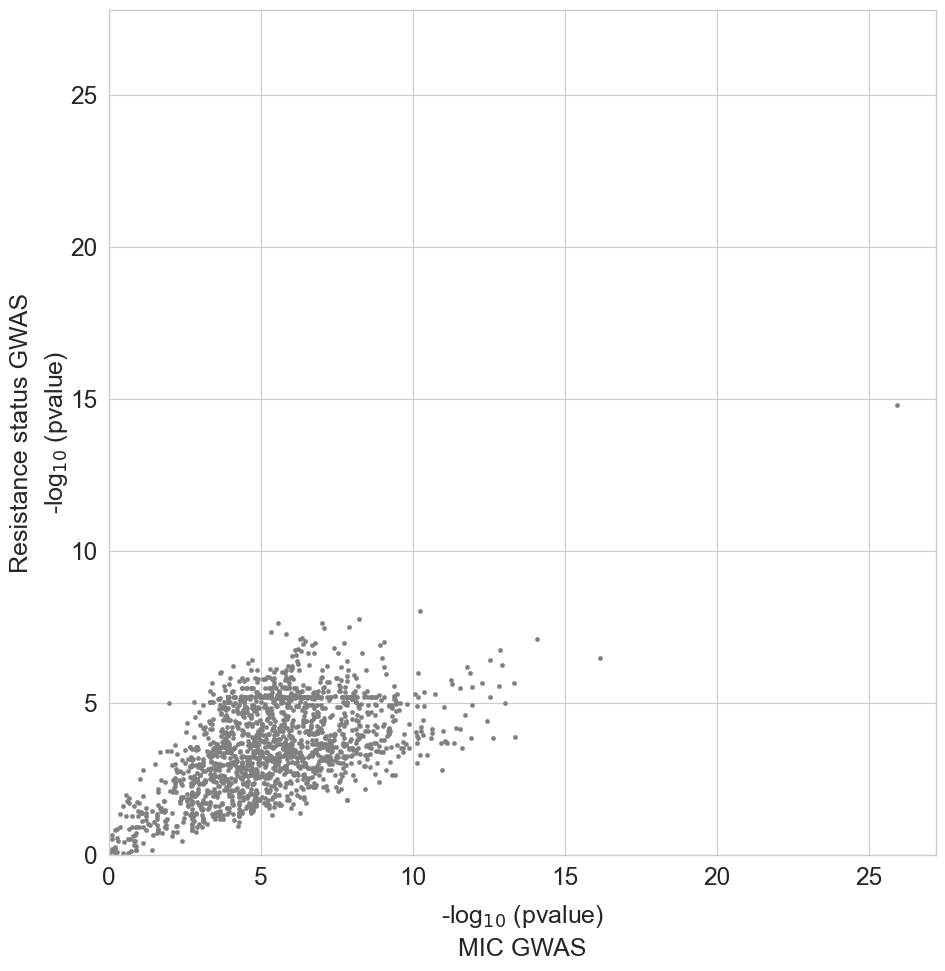

In [643]:

sns.set_context('paper', font_scale=2)
sns.set_style('whitegrid') #  {darkgrid, whitegrid, dark, white, ticks}
# sns.despine()
fig, ax = plt.subplots(figsize=(10,10))

fontsize_genes = 'small'


sns.scatterplot(data=df_genes_intersect, x='pvalue_linreg_log10', y='pvalue_logreg_log10', s=10, color='grey', edgecolor=None, ax=ax)
# ax.set(xlabel='-log$_{10}$ (pvalue) \n linear regression', ylabel='-log$_{10}$ (pvalue) \n logistic regression')
ax.set(xlabel='', ylabel='')

ax.text(0.5, -0.08, "-log$_{10}$ (pvalue)", fontsize=18, ha='center', transform=ax.transAxes)
ax.text(0.5, -0.12, "MIC GWAS", fontsize=18, ha='center', transform=ax.transAxes)


ax.text(-0.12, 0.5, "Resistance status GWAS" , fontsize=18, va='center',  rotation='vertical', transform=ax.transAxes)
ax.text(-0.08, 0.5, "-log$_{10}$ (pvalue)" , fontsize=18, va='center',  rotation='vertical', transform=ax.transAxes)

# ax.set_yticks([0,2,4,6,8,10,12,14])
# ax.set_yticks([0,5,10,15,20,25])

plt.axis('square')
ax.set_xlim(0)
ax.set_ylim(0)



fig.tight_layout()
plt.show()
# fig.savefig("../test/revision-figure4/genes_all.png")


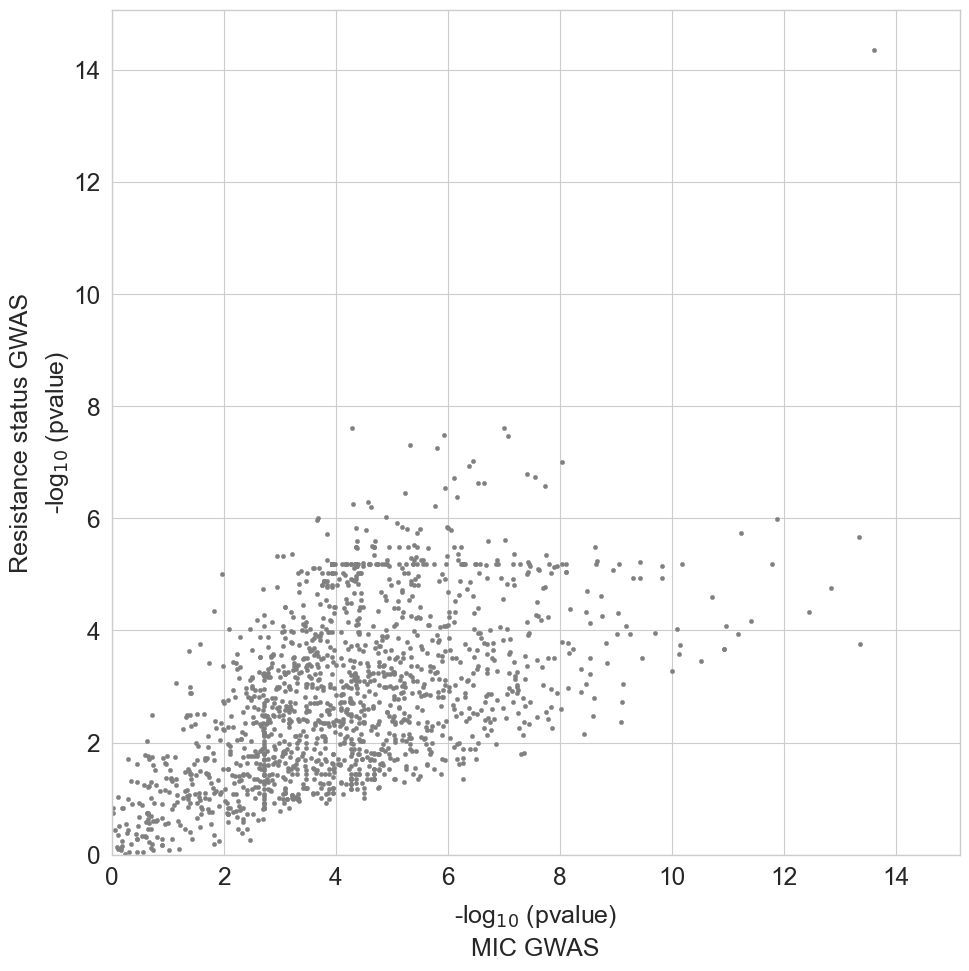

In [644]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper', font_scale=2)
sns.set_style('whitegrid') #  {darkgrid, whitegrid, dark, white, ticks}
# sns.despine()
fig, ax = plt.subplots(figsize=(10,10))

fontsize_genes = 'small'

sns.scatterplot(data=df_genes_intersect_nonsym, x='pvalue_linreg_log10', y='pvalue_logreg_log10', s=10, color='grey', edgecolor=None, ax=ax)
# ax.set(xlabel='-log$_{10}$ (pvalue) \n linear regression', ylabel='-log$_{10}$ (pvalue) \n logistic regression')
ax.set(xlabel='', ylabel='')


ax.text(0.5, -0.08, "-log$_{10}$ (pvalue)", fontsize=18, ha='center', transform=ax.transAxes)
ax.text(0.5, -0.12, "MIC GWAS", fontsize=18, ha='center', transform=ax.transAxes)


ax.text(-0.12, 0.5, "Resistance status GWAS" , fontsize=18, va='center',  rotation='vertical', transform=ax.transAxes)
ax.text(-0.08, 0.5, "-log$_{10}$ (pvalue)" , fontsize=18, va='center',  rotation='vertical', transform=ax.transAxes)

# ax.set_yticks([0,2,4,6,8,10,12,14,16])

# ax.set_xlim(0,14)
# ax.set_ylim(0)

plt.axis('square')
ax.set_xlim(0)
ax.set_ylim(0)

fig.tight_layout()
plt.show()

# fig.savefig("../test/revision-figure4/genes_nonsynonymous.png")


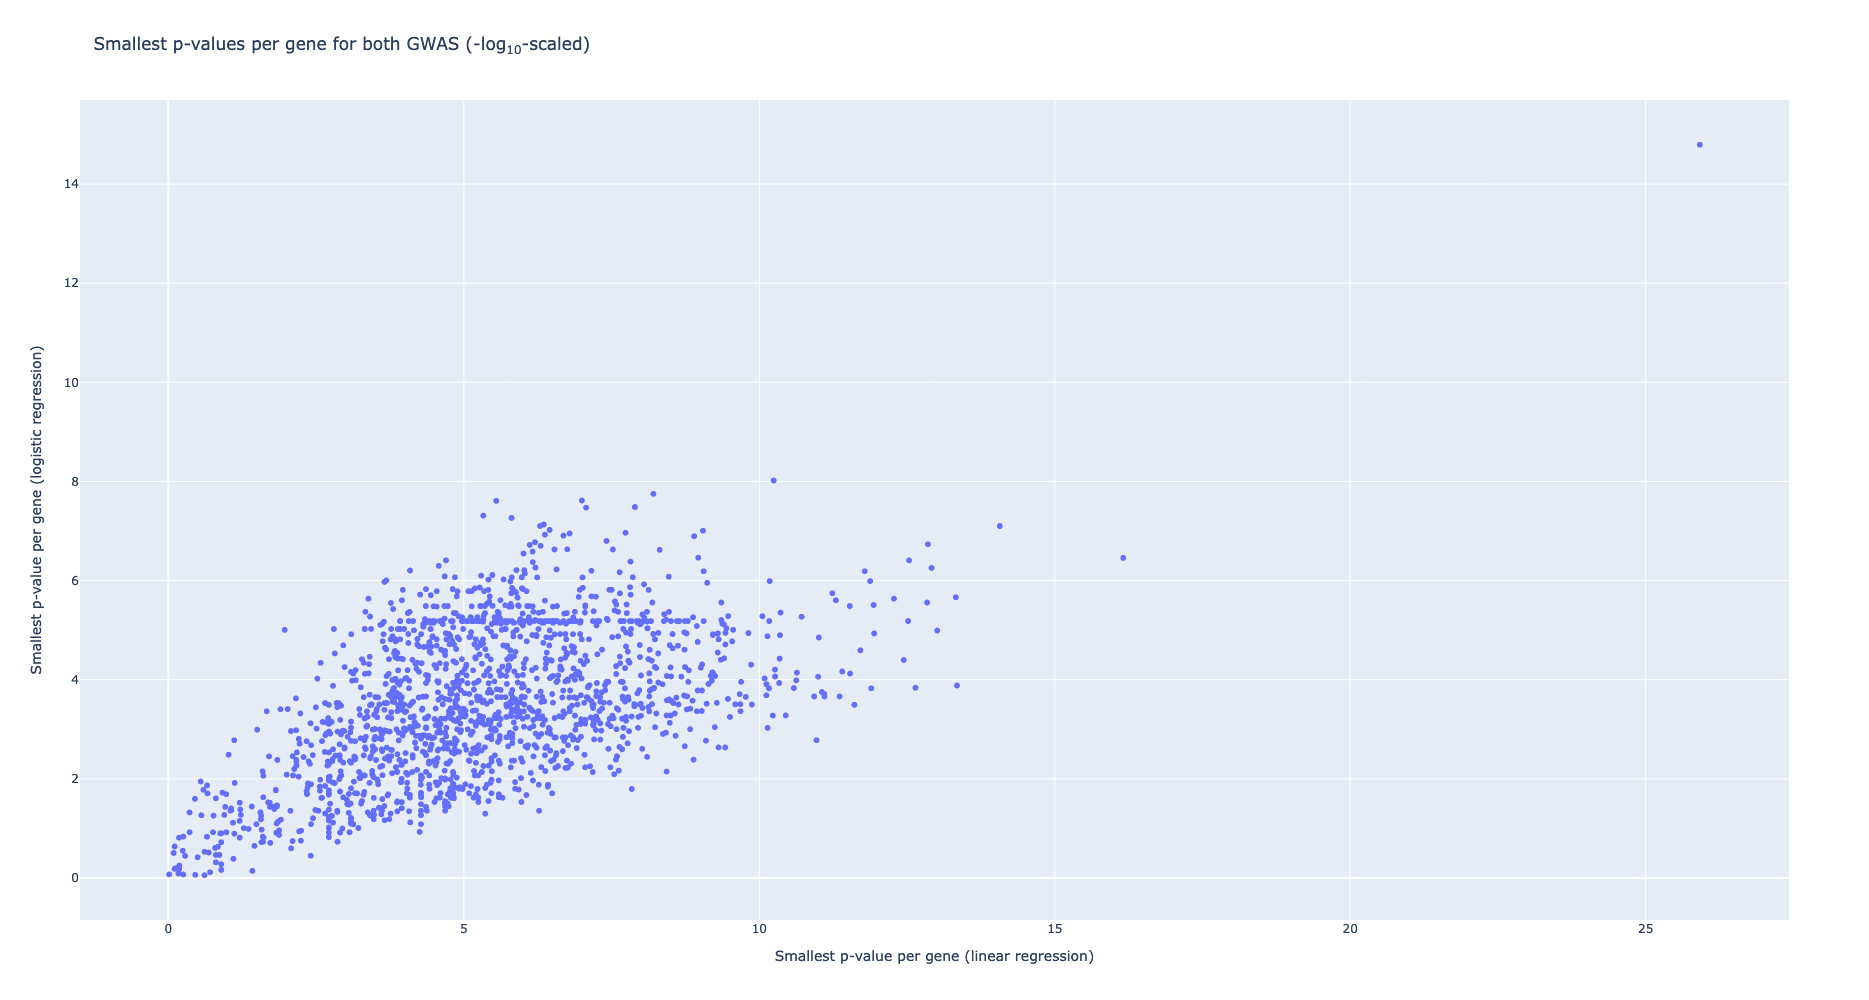

'../test/revision-html/Suppl_Material_5_genes_all.html'

In [752]:
hover_data = ['variant_position_linreg', 'variant_position_logreg', 'mutation_linreg', 'mutation_logreg', 'gene.name_linreg','gene.product_linreg', 'gene.type_linreg', 'gene.id', 'MAC_linreg', 'MAC_logreg']

labels = {'gene.id' : 'GeneID',
          'pvalue_linreg_log10': 'Smallest p-value per gene (linear regression)',
          'pvalue_logreg_log10': 'Smallest p-value per gene (logistic regression)',
          '-log_10(pvalue)': '-log<sub>10</sub> (p-value)',
          'variant_position_linreg': 'Variant position (linear)',
          'variant_position_logreg': 'Variant position (logistic)',
          'mutation_linreg': 'Mutation (linear)',
          'mutation_logreg': 'Mutation (logistic)',
          'gene.name_linreg': 'Gene name',
          'gene.product_linreg': 'Gene product',
          'gene.type_linreg': 'Gene type',
          'MAC_linreg': 'Minor allle count (linear)',
          'MAC_logreg': 'Minor allle count (logistic)'
         }

fig = px.scatter(df_genes_intersect.fillna(' '), x='pvalue_linreg_log10', y='pvalue_logreg_log10', hover_data=hover_data, hover_name='gene.name_linreg',
                                                 title='Smallest p-values per gene for both GWAS (-log<sub>10</sub>-scaled)',
                                                 labels=labels,
                                                 width=1000, height=1000)

fig.show()
# plotly.offline.plot(fig, filename='../test/revision-html/Suppl_Material_5_genes_all.html')

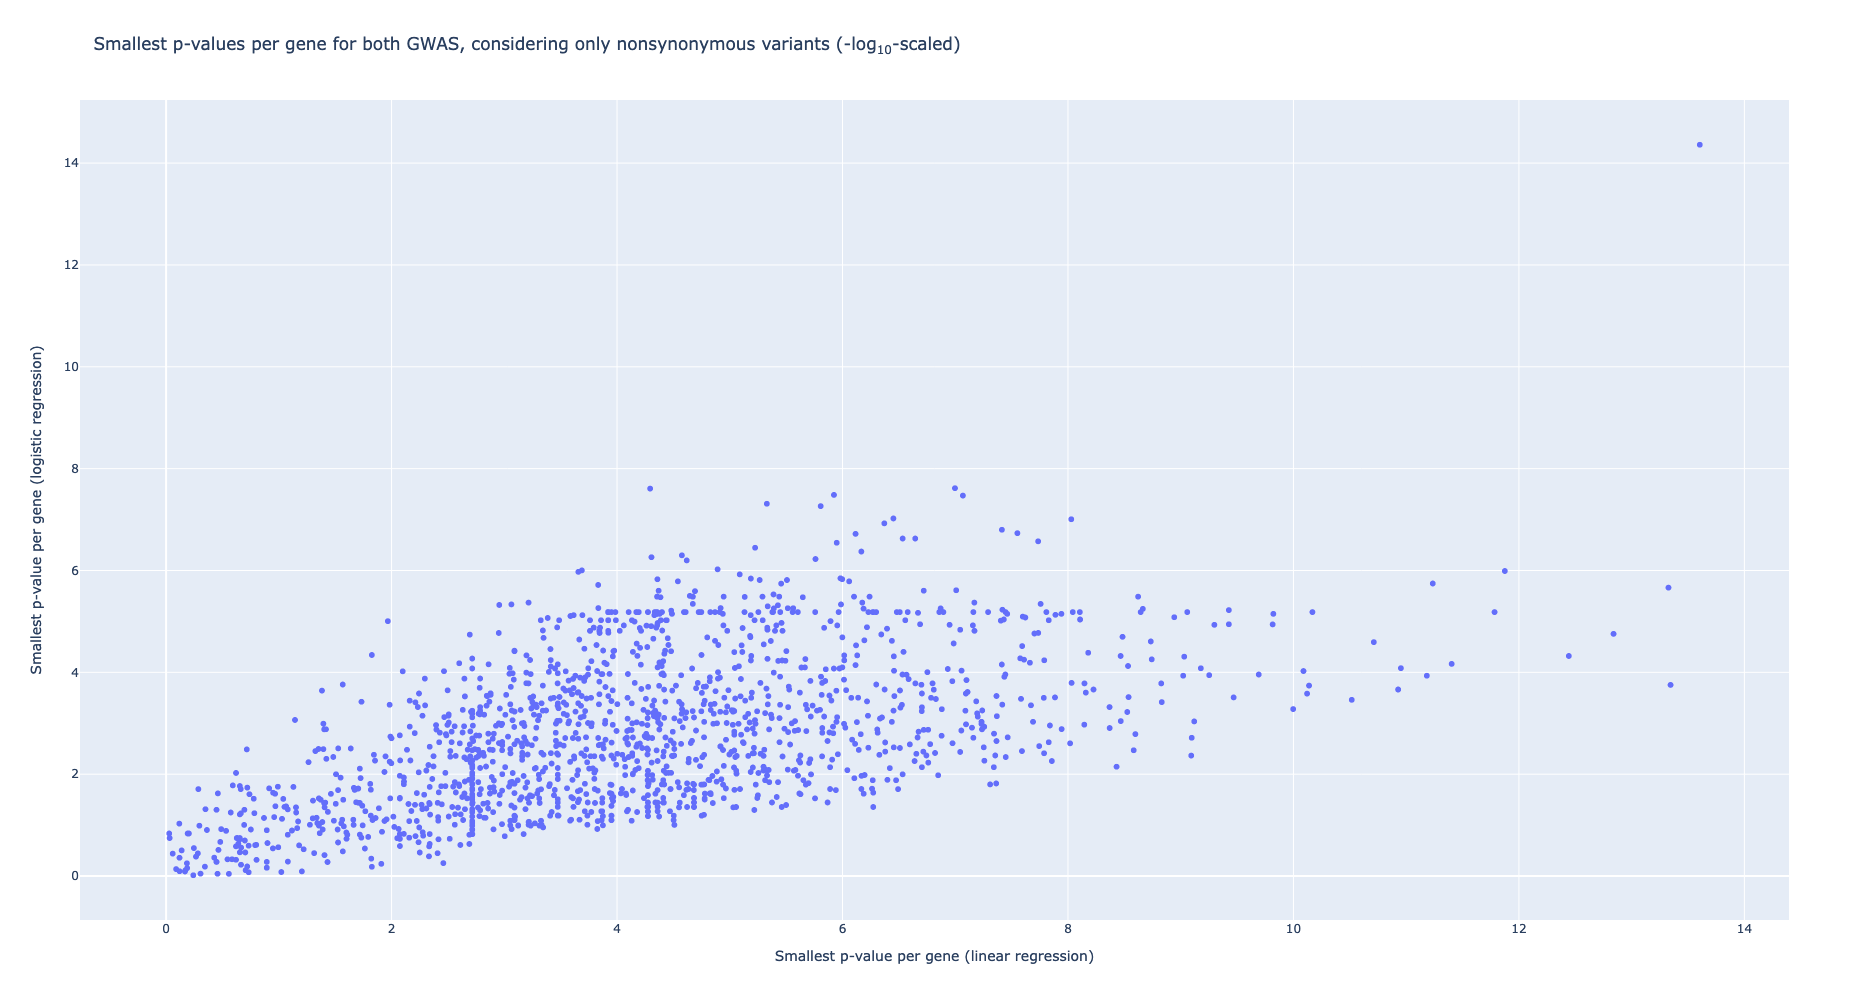

'../test/revision-html/Suppl_Material_6_genes_nonsynonymous.html'

In [751]:
hover_data = ['variant_position_linreg', 'variant_position_logreg', 'mutation_linreg', 'mutation_logreg', 'gene.name_linreg','gene.product_linreg', 'gene.type_linreg', 'gene.id', 'MAC_linreg', 'MAC_logreg']

labels = {'gene.id' : 'GeneID',
          'pvalue_linreg_log10': 'Smallest p-value per gene (linear regression)',
          'pvalue_logreg_log10': 'Smallest p-value per gene (logistic regression)',
          '-log_10(pvalue)': '-log<sub>10</sub> (p-value)',
          'variant_position_linreg': 'Variant position (linear)', 
          'variant_position_logreg': 'Variant position (logistic)',
          'mutation_linreg': 'Mutation (linear)',
          'mutation_logreg': 'Mutation (logistic)',
          'gene.name_linreg': 'Gene name',
          'gene.product_linreg': 'Gene product',
          'gene.type_linreg': 'Gene type',
          'MAC_linreg': 'Minor allle count (linear)',
          'MAC_logreg': 'Minor allle count (logistic)'
         }

fig = px.scatter(df_genes_intersect_nonsym.fillna(' '), x='pvalue_linreg_log10', y='pvalue_logreg_log10', hover_data=hover_data, hover_name='gene.name_linreg',
                                                 title='Smallest p-values per gene for both GWAS, considering only nonsynonymous variants (-log<sub>10</sub>-scaled)',
                                                 labels=labels,
                                                 width=1000, height=1000)

fig.show()
# plotly.offline.plot(fig, filename='../test/revision-html/Suppl_Material_6_genes_nonsynonymous.html')

In [197]:
# ftsI 1688287 bis 1690121, transpeptidase 1688532 bis 1689075
ds_ftsI = ds_logreg.sel(variants=((1688287 < ds_logreg.variant_position) & (ds_logreg.variant_position < 1690121)))
# print(ds_ftsI['mutation'].values)
# print(ds_ftsI['variant_position'].values)
# print(ds_ftsI['variant_allele'].values)
# ds_ftsI.sel(variants=ds_ftsI['mutation'])
ref = ds_ftsI['mutation'].to_series().str.split().str[0].str[0]
alt = ds_ftsI['mutation'].to_series().str.split().str[0].str[-1]
mask_mut = ~(ref == alt)
ds_ftsI = ds_ftsI.sel(variants=mask_mut.values)#['mutation'].values.shape

## VCF export and Ld-plots

In [32]:
import sgkit as sg
from sgkit.io.vcf import write_vcf, zarr_to_vcf


input_zarr = '../results/zarrs/Hinf_norm_mic_linreg_logscaled_results.zarr/'
output_vcf = '../results/linreg-lisbon-both/linreg_nonsynonymous_ftsI.vcf'

ds_results = sg.load_dataset(input_zarr)

# Extract just the ftsI positions
# ftsI 1688288 to 1690120, transpeptidase 1688533 to 1689074
ds_ftsI = ds_results.sel(variants=((1688288 < ds_results.variant_position) & (ds_results.variant_position < 1690120)))

# We just want to have the nonsynonymous variants
ref = ds_ftsI['mutation'].to_series().str.split().str[0].str[0]
alt = ds_ftsI['mutation'].to_series().str.split().str[0].str[-1]
mask_mut = ~(ref == alt)

ds_ftsI_nonsym = ds_ftsI.sel(variants=mask_mut.values)
ds_ftsI_nonsym['variant_id'] = ds_ftsI_nonsym['mutation']
# artificially fix the zarr, so that a vcf can be generated
# not perfect, but should have no consequences on the subsequent steps
ds_ftsI_nonsym.attrs = {'contig_lengths': [1830701],
                 'contigs': ['Hinf_Rd-KW20v3'],
                 'filters': ['PASS', 'LowQual'],
                 'max_alt_alleles_seen': 1,
                 'source': 'sgkit-0.8.0',
                 'vcf_zarr_version': '0.2'}
# sg.save_dataset(ds_ftsI, 'test/ftsI.zarr')
# zarr_to_vcf('test/ftsI.zar/', 'test/ftsI.vcf',vcf_header='')
write_vcf(ds_ftsI_nonsym, output_vcf)

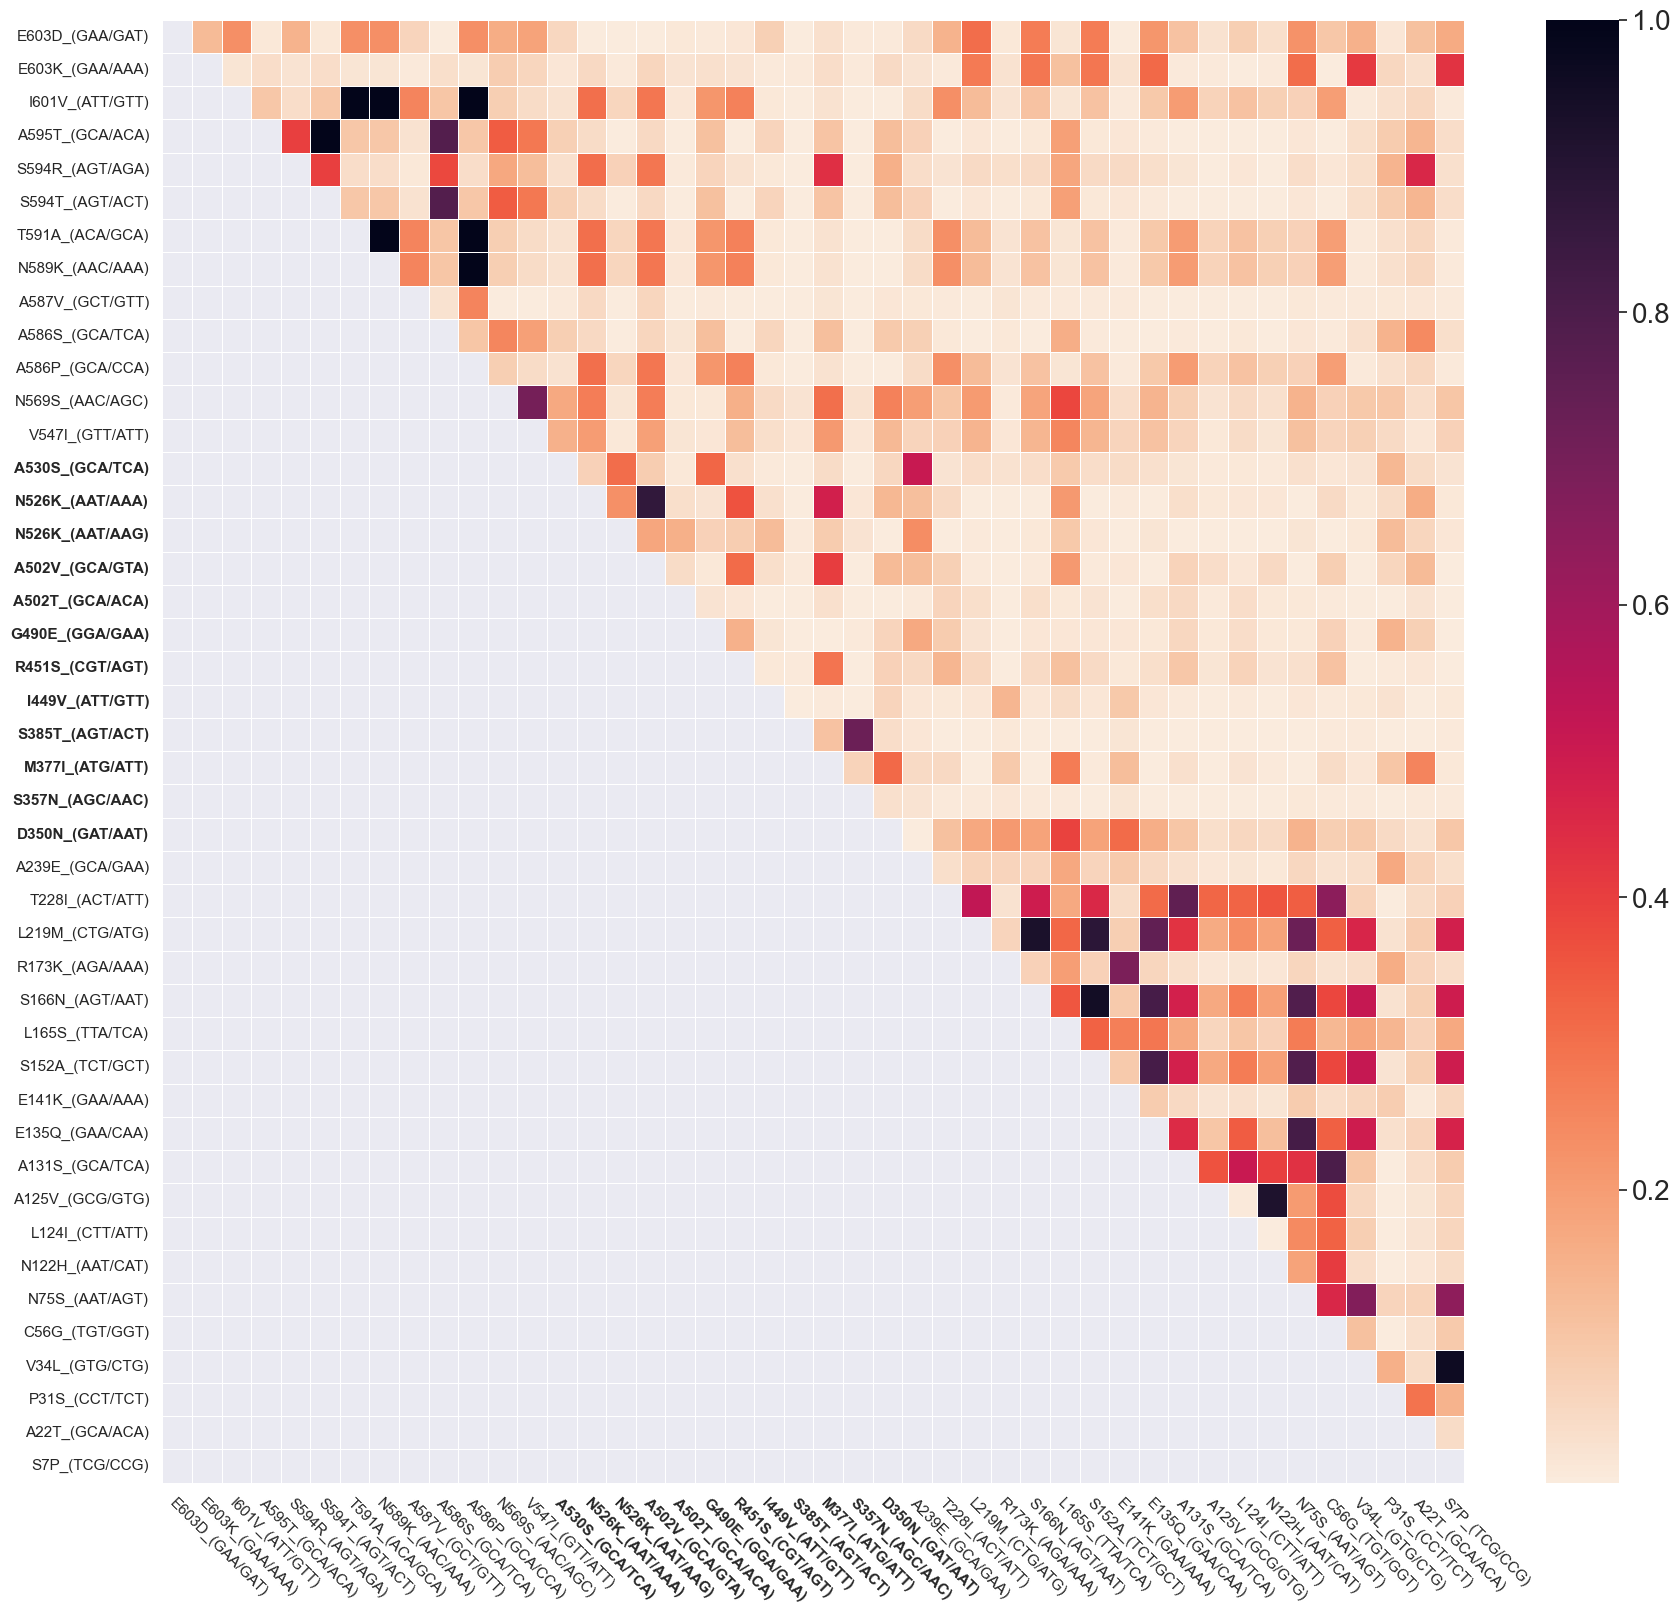

In [726]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ld = pd.read_fwf('../results/linreg-lisbon-both/ld_results.ld').drop(columns=['CHR_A', 'BP_A','CHR_B', 'BP_B'])
haha = ds_ftsI_nonsym.mutation.to_pandas().str.split().str.join('_')
df_ld = df_ld.pivot(index='SNP_A', columns='SNP_B', values="R2").reindex(index=haha, columns=haha)
sns.set(rc={'figure.figsize':(21,19)})
# sns.set(font_scale=1)
# crest flare
ax = sns.heatmap(df_ld, cmap='rocket_r', linewidths=.5)


# Adjust tick label size
ax.figure.axes[-1].tick_params(labelsize=20)
ax.grid(False)

# Adjust axis ticks
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor');

_, xlabels = plt.xticks()
_, ylabels = plt.yticks()
bold_indices = range(13,25)

for i, label in enumerate(zip(xlabels,ylabels)):
    if i in bold_indices:
        label[0].set_fontweight('bold')
        # label[0].set_color('red')
        label[1].set_fontweight('bold')

fig = ax.get_figure()
# fig.savefig('../test/revision_ld/Suppl_Figure_S11_ld_ftsI.pdf')


In [598]:
seaborn_palette = sns.color_palette("rocket_r", n_colors=1000)
plotly_palette = [f"rgb({c[0]*256}, {c[1]*256}, {c[2]*256})" for c in seaborn_palette]

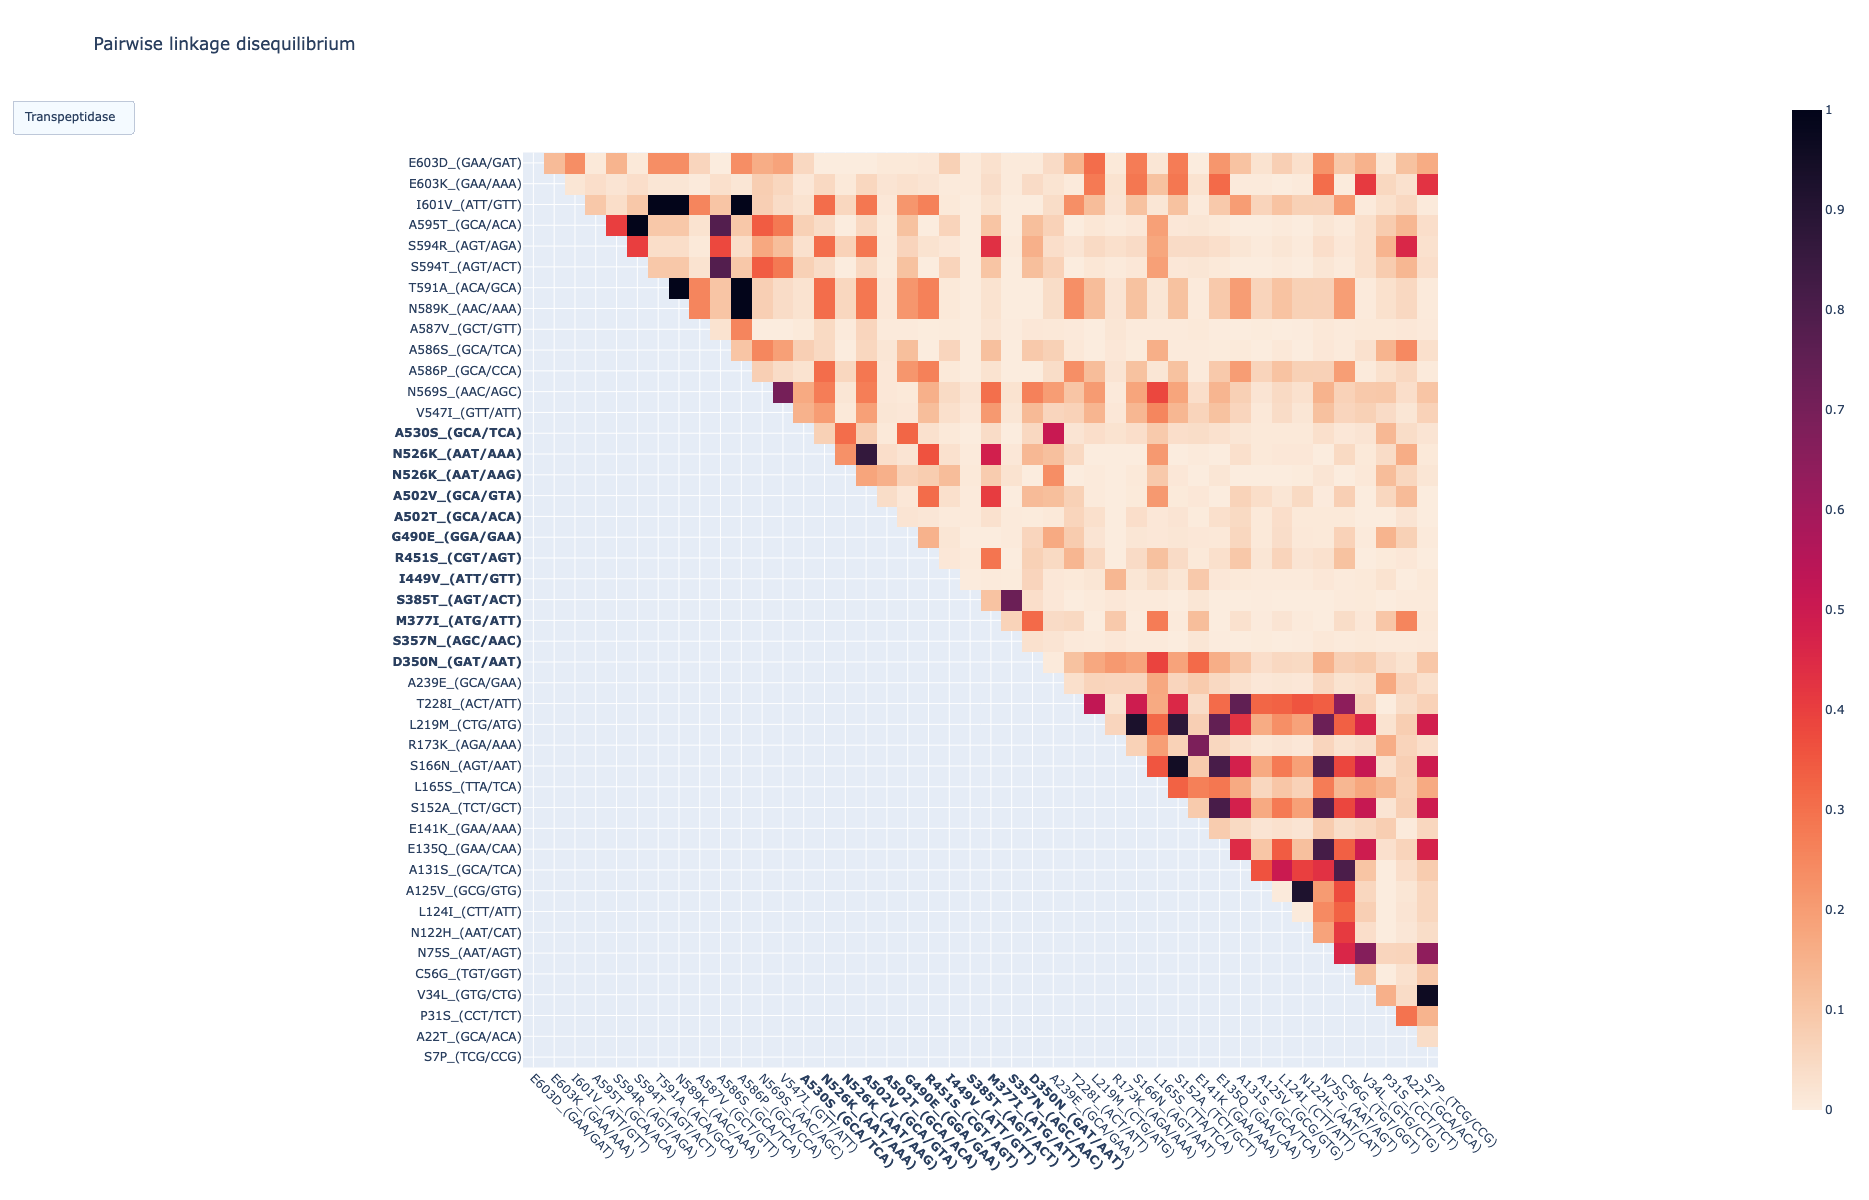

'../test/revision-html/Suppl_Material_7_ld_ftsI.html'

In [766]:
import sgkit as sg

import plotly.express as px
import plotly



# Darkmint Darkmint
fig = px.imshow(df_ld, width=1200, height=1200, color_continuous_scale=plotly_palette, labels={},
                title='Pairwise linkage disequilibrium')

fig.update_xaxes(tickangle=45)
# fig.update_yaxes(tickfont=dict(weight='bold'))

fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        buttons=[dict(label='Transpeptidase', method='relayout', args=[{'xaxis.range': [13, 25], 'yaxis.range': [25, 13]}])]
    )]
)

fig.data[0]['x'][13:25] = [f'<b>{pos}</b>' for pos in fig.data[0]['x'][13:25]]
fig.data[0]['y'][13:25] = [f'<b>{pos}</b>' for pos in fig.data[0]['y'][13:25]]

fig.show()

# plotly.offline.plot(fig, filename='../test/revision-html/Suppl_Material_7_ld_ftsI.html')

## PCA plot

In [784]:
from sklearn.decomposition import PCA
import re
from bokeh.plotting import figure, show, output_notebook, output_file, ColumnDataSource, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.io import export_svg

ds_logreg_ = sg.load_dataset('../results-revision-lisbon-both3/zarrs/Hinf_norm_bin_logreg_results.zarr/')
X = ds_logreg_['call_genotype'].values.squeeze().transpose()


pca = PCA(n_components=2)
X_trns = pca.fit_transform(X)

data = ds_logreg_[['sample_id', 'Institute', 'AMP', 'AMP_MIC', 'HaemoSeq_serotype', 'Haplotype', 'SequenceType', 'group']].to_pandas()
data['PC1'] = X_trns[:,0]
data['PC2'] = X_trns[:,1]
source = data#ColumnDataSource(data)

SEROTYPES = sorted(data.HaemoSeq_serotype.unique())
MARKERS = ['hex', 'circle_x', 'triangle', 'square']
ORIGINS = sorted(data.Institute.unique())

TOOLTIPS = [
    ("Sample", "@sample_id"),
    ("Institute", "@Institute"),
    ("Resistance status", "@AMP"),
    ("Ampicillin-MIC", "@AMP_MIC"),
    ("Serotype", "@HaemoSeq_serotype"),
    ("Haplotype", "@Haplotype"),
    ("Sequence type", "@SequenceType"),
    ("Group", "@group"),
]

# output_notebook()
p = figure(title='PCA plot of the genotype matrix', tooltips=TOOLTIPS, width=800, height=800)
# p.output_backend = "svg"


# p.scatter('PC1', 'PC2', source=source, legend_group='serotype', fill_alpha=0.4, size=20,
#            color=factor_cmap('serotype', 'Category10_3', SEROTYPES))

p.circle('PC1', 'PC2', source=source, legend_group='HaemoSeq_serotype', fill_alpha=0.4, size=10,
           color=factor_cmap('HaemoSeq_serotype', 'Category10_5', SEROTYPES))

pca_explained_ratios = pca.explained_variance_ratio_ * 100

p.xaxis.axis_label = f"PC1 ({pca_explained_ratios[0]:.2f}%)"
p.yaxis.axis_label = f"PC2 ({pca_explained_ratios[1]:.2f}%)"
p.legend.location = 'top_right'
show(p)

output_file(filename="../test/revision-html/Suppl_Material_2_pca.html", title="PCA on linear regression dataset")
save(p)
# export_svg(p, filename="PCA.svg")

'/Users/lbartels/Documents/2023_haemophilius_gwas/hinf/test/revision-html/Suppl_Material_2_pca.html'

## Variant counts

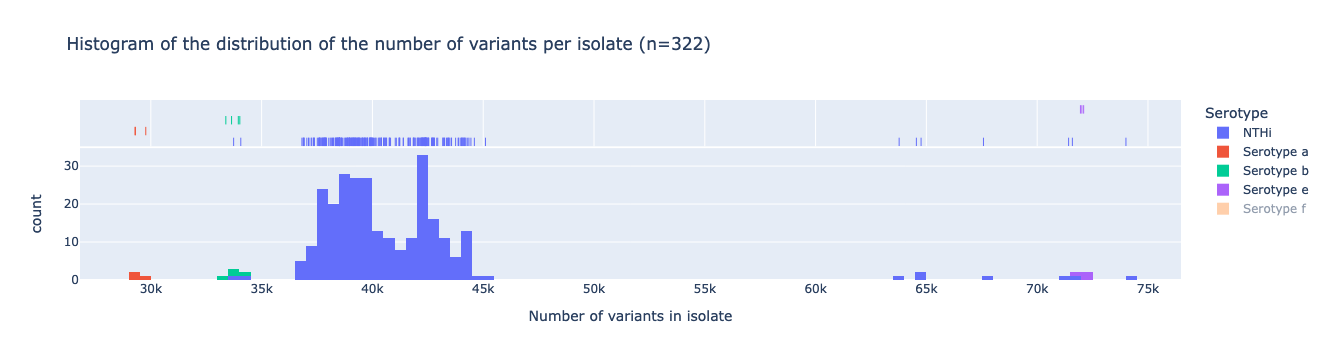

'../test/revision-html/Suppl_Material_1_variant_count_histogram.html'

In [764]:
import pandas as pd
import plotly.express as px

df_variant_count = pd.read_csv('../results/stats_gwas.tsv', sep='\t', names=['SampleID', 'record_count', 'het1', 'het2']).assign(SampleID= lambda df: df['SampleID'].str.split('_').str[0])
df_data = pd.read_csv("../vcf_Haemophilus/annotation_files/HLR-metadata-322.tsv", sep='\t')

df_metadata = pd.merge(df_data, df_variant_count, left_on='ID',right_on='SampleID')

orders = {'HaemoSeq_serotype': ['NTHi', 'Serotype a', 'Serotype b', 'Serotype e', 'Serotype f']}

hover_data = ['Institute', 'HaemoSeq_species', 'HaemoSeq_serotype', 'SequenceType',
              'AMP', 'AMP_MIC', 'group', 'Haplotype', 'perc_reads_mapped',
              'coverage_mapped_reads', 'record_count']

labels = {'Institute' : 'Institute',
          'HaemoSeq_species': 'Species',
          'HaemoSeq_serotype': 'Serotype',
          'SequenceType': 'Sequence type',
          'AMP': 'Resistance status', 
          'AMP_MIC': 'Ampicillin-MIC',
          'group': 'Resistence group',
          'Haplotype': 'Haplotype',
          'perc_reads_mapped': 'Reads mapped (%)',
          'coverage_mapped_reads': 'Coverage of mapped reads (%)',
          'record_count': 'Number of variants in isolate'
         }


fig = px.histogram(df_metadata.fillna(' '), x="record_count", nbins=100, color='HaemoSeq_serotype',  marginal="rug", hover_data=hover_data, hover_name='SampleID', labels=labels, category_orders=orders,
                  title='Histogram of the distribution of the number of variants per isolate (n=322)')
fig.show()
plotly.offline.plot(fig, filename='../test/revision-html/Suppl_Material_1_variant_count_histogram.html')

# misc

In [99]:
def resistance_groups_map(group : str) -> str:
    
    
    gr_I = ('I')
    gr_II = ('IIa', 'IIb', 'IIb (+M377I)', 'IIc', 'IId')
    gr_III = ('III')
    gr_III_plus = ('III+')
    gr_III_like = ('III-like')
    gr_III_like_plus = ('III-like+')
    gr_miscellaneous = ('Miscellaneous (no group-specific mutation; V509I',
                        'Miscellaneous (no group-specific mutation; A429V)',
                        'Miscellaneous (no group-specific mutation; A437S; D350N)',
                        'Miscellaneous (no group-specific mutation; A437S)',
                        'Miscellaneous (no group-specific mutation; D350N)',
                       'Miscellaneous (no group-specific mutation; A368T)',
                       'Miscellaneous (no group-specific mutation; A454V)')
    gr_no_subs = ('No non-synonymous substitution between AA 350-530')
    
    if group in gr_II:
        return 'II'
    elif group in gr_no_subs:
        return 'no substitution AA 350-530'
    elif group in gr_miscellaneous:
        return 'miscellaneous'
    else:
        return group
    # elif group in gr_III_like_plus

def transform2category(i):
    
    lookup = {
        'I':0,
        'II':1,
        'III':2,
        'III+':3,
        'III-like':4,
        'III-like+':5,
        'miscellaneous':6,
        'no substitution AA 350-530':7
    }
    return lookup[i]
    
# print(ds_ftsI_nonsym[['sample_id', 'group']].to_pandas()['group'].apply(resistance_groups_map).value_counts())
df_ftsI_nonsym = ds_ftsI_nonsym[['sample_id', 'group']].to_pandas()
df_ftsI_nonsym['group'] = df_ftsI_nonsym['group'].apply(resistance_groups_map).apply(transform2category)
df_ftsI_nonsym.transpose().to_csv('../test/tmep/linreg_groups.tsv', sep='\t')


## Count heterozygous calls for a given position

In [803]:
import xarray as xr
def count_heterozygous(ds: xr.Dataset, position: int):
    ds_temp = ds.sel(variants=(ds.variant_position==position).compute())
    return (ds_temp['call_genotype'][:,:,0].values != ds_temp['call_genotype'][:,:,1].values).sum()
    

ds_hinf_norm = sg.load_dataset('../results/zarrs/Hinf_norm.zarr/').set_index({'samples':'sample_id'})
# ftsI 1688287 bis 1690121, transpeptidase 1688532 bis 1689075
ds_hinf_norm_ftsI = ds_hinf_norm.sel(variants=((1688287 < ds_hinf_norm.variant_position) & (ds_hinf_norm.variant_position < 1690121)).compute())
# (ds_hinf_norm_ftsI['call_genotype'][:,:,0].values != ds_hinf_norm_ftsI['call_genotype'][:,:,1].values).sum()
count_heterozygous(ds_hinf_norm_ftsI, 1688415)
# ds_hinf_norm_ftsI.sel(variants=(ds_hinf_norm_ftsI.variant_position==1688415).compute())
(ds_hinf_norm_ftsI['call_genotype'][:,:,0] != ds_hinf_norm_ftsI['call_genotype'][:,:,1]).sum(dim='variants').to_pandas().sort_values()#.value_counts()
# ds_hinf_norm

samples
HLR-423     0
HLR-224     0
HLR-514     0
HLR-286     0
HLR-473     0
           ..
HLR-321     0
HLR-150     0
HLR-201     1
HLR-416    11
HLR-513    18
Length: 516, dtype: int64